In [847]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import haversine_distances

In order to avoid crashing the kernel, only read a portion of the data

In [848]:
df = pd.read_csv('train.csv', nrows = 1_000_000)
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In order to determine the amount of distance traveled, use the Haversine formula

Note, I didn't use Euclidean distance because the coordinates are points on a sphere. 

In [849]:
def hav_distance(lon1, lat1, lon2, lat2):
    # use sklearn's haversine function and multiply by Earth's radius to get distance in km
    return haversine_distances([[lon1, lat1], [lon2, lat2]])[0][1] * 6371000/1000

# create new feature using this function, distance in km
df['distance_traveled_km'] = df.apply(lambda x: hav_distance(x['pickup_longitude'], x['pickup_latitude'], 
                                                             x['dropoff_longitude'], x['dropoff_latitude']), axis=1)

Add two more features for difference in longitude and latitude

In [850]:
def distance_diff(start, end):
    return abs(end - start)

df['lat_dif'] = df.apply(lambda x: distance_diff(x['pickup_longitude'], x['dropoff_longitude']), axis=1)
df['lon_dif'] = df.apply(lambda x: distance_diff(x['pickup_latitude'], x['dropoff_longitude']), axis=1)

To clean the data, drop any NaNs from the df

In [851]:
df = df.dropna(axis='rows')
print('New number of observations: %d' % len(df))

New number of observations: 999990


Find distribution of the distance traveled

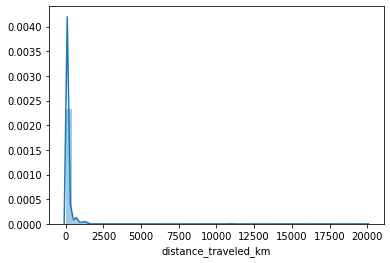

In [852]:
sns.distplot(df['distance_traveled_km'])

In [853]:
df['distance_traveled_km'].quantile(.95)

621.2290233476851

Some of the observations are too high to make sense, so take out all of the rows where the distance traveled is above the 95th percentile, then also take out all of the rows where the distances is 0

In [854]:
df = df[df['distance_traveled_km'] <= df['distance_traveled_km'].quantile(.95)]
df = df[df['distance_traveled_km'] > 0]
df['distance_traveled_km'].describe()

count    921504.000000
mean        107.724525
std          96.291255
min           0.000214
25%          42.439587
50%          80.011456
75%         141.368595
max         621.220036
Name: distance_traveled_km, dtype: float64

New distribution after the filtering

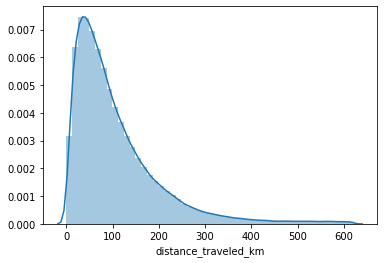

In [855]:
sns.distplot(df['distance_traveled_km'])

Some of the fares also make no sense, so fix that too.

Since as of 2018, the lowest base fee for a taxi ride in NYC is $2.50, I'll drop observations with fare_amount below 1.5

In [856]:
df = df[df['fare_amount'] > 1.5]

In [857]:
df['fare_amount'].quantile(.999)

57.33

If the 99.9th percentile is less than 58, it looks safe to just cut out values >= 60

In [858]:
df = df[df['fare_amount'] < 60]
df['fare_amount'].describe()

count    920744.000000
mean          9.757954
std           5.886955
min           2.500000
25%           6.000000
50%           8.100000
75%          11.700000
max          59.830000
Name: fare_amount, dtype: float64

Text(0.5, 1.0, 'Histogram')

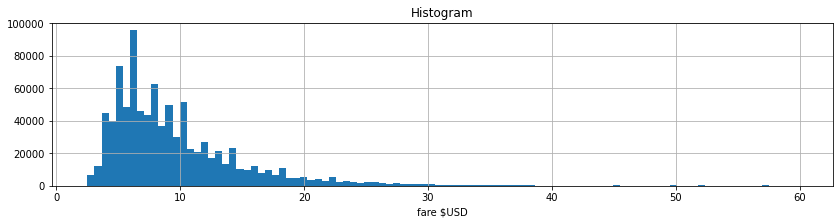

In [859]:
df.fare_amount.hist(bins=100, figsize=(14,3))
plt.xlabel('fare $USD')
plt.title('Histogram')

Then cut out all of the rows where the passenger count is zero

In [860]:
df = df[df['passenger_count'] > 0]

In [861]:
df[['pickup_latitude', 'pickup_longitude']].describe()

,pickup_latitude,pickup_longitude
count,917330.000000,917330.000000
mean,40.694324,-73.916658
std,2.706547,2.633202
min,-74.016587,-121.391210
25%,40.737075,-73.992561
50%,40.753385,-73.982383
75%,40.767190,-73.969800
max,424.083332,40.812887


Clearly some of longitudes and latitudes do not make sense. 40 degrees lattitude is well into NJ,
so any rows with < 40 latitude should be dropped. Similarly anything > 42 degrees lattitude is very north of NYC and should also be dropped

As for longitude, anything above -72 degrees is east of Long Island and should be dropped. Anything below -75 is far west of NYC and should also be cut

In [862]:
# cut rows with latitude <= 40
df = df[df['pickup_latitude'] > 40]

# cut rows with latitude >= 42
df = df[df['pickup_latitude'] < 42]

# cut rows with longitude >= -72
df = df[df['pickup_longitude'] < -72]

# cut rows with longitude <= -75
df = df[df['pickup_longitude'] > -75]

I think the time of day may be relevant to the fares, so I'll create a new feature called pickup_hour that will have the hour of the day extracted from the datetime stamp

In [863]:
# function to parse datetime stamp and extract hour of the day
def time_parse(time_str):
    time = time_str.split()[1]
    return int(time.split(":")[0])

df['pickup_hour'] = df.apply(lambda x: time_parse(x['pickup_datetime']), axis=1)

Then, try fitting multiple linear regression model to training data, then test with test.csv

Text(0.5, 1.0, 'Pickup Hour Distribution')

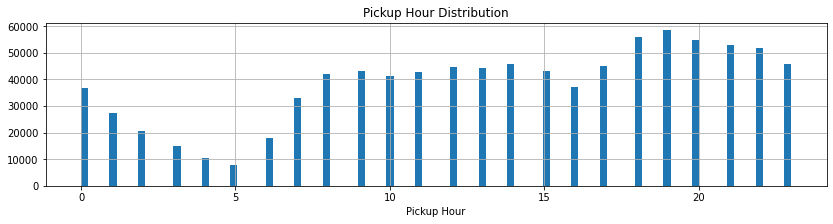

In [864]:
df.pickup_hour.hist(bins=100, figsize=(14,3))
plt.xlabel('Pickup Hour')
plt.title('Pickup Hour Distribution')

In [865]:
df['fare_amount'].describe()

count    916700.000000
mean          9.763159
std           5.890711
min           2.500000
25%           6.000000
50%           8.100000
75%          11.700000
max          59.830000
Name: fare_amount, dtype: float64

Next figure out the average fare for each hour

In [866]:
means = df.groupby('pickup_hour')['fare_amount'].mean()
means

pickup_hour
0     10.645764
1     10.617459
2     10.684989
3     10.996552
4     11.245043
5     10.552074
6      9.095901
7      9.132586
8      9.492579
9      9.507556
10     9.398372
11     9.497832
12     9.517612
13     9.559249
14     9.597877
15     9.594305
16     9.426025
17     9.611208
18     9.627188
19     9.445463
20     9.585508
21     9.860345
22    10.184498
23    10.418996
Name: fare_amount, dtype: float64

Add another feature for the fares categorized into bins of every $5 to see the most common ranges

In [867]:
df['fare_bin'] = pd.cut(df['fare_amount'], bins = list(range(0, 50, 5))).astype(str)
df['fare_bin'].describe()

count          916700
unique             10
top       (5.0, 10.0]
freq           453052
Name: fare_bin, dtype: object

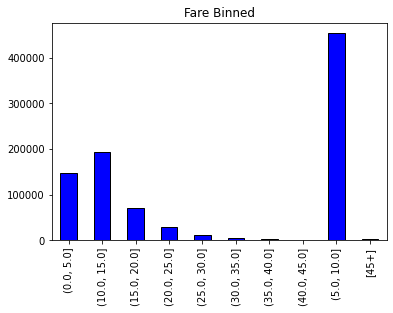

In [868]:
# Uppermost bin
df.loc[df['fare_bin'] == 'nan', 'fare_bin'] = '[45+]'

# Bar plot of value counts
df['fare_bin'].value_counts().sort_index().plot.bar(color = 'b', edgecolor = 'k');
plt.title('Fare Binned');

There doesn't seem to be a huge difference between the different averages based on time of day

I wanted to see which features may prove useful in a model so I created a correlation matrix

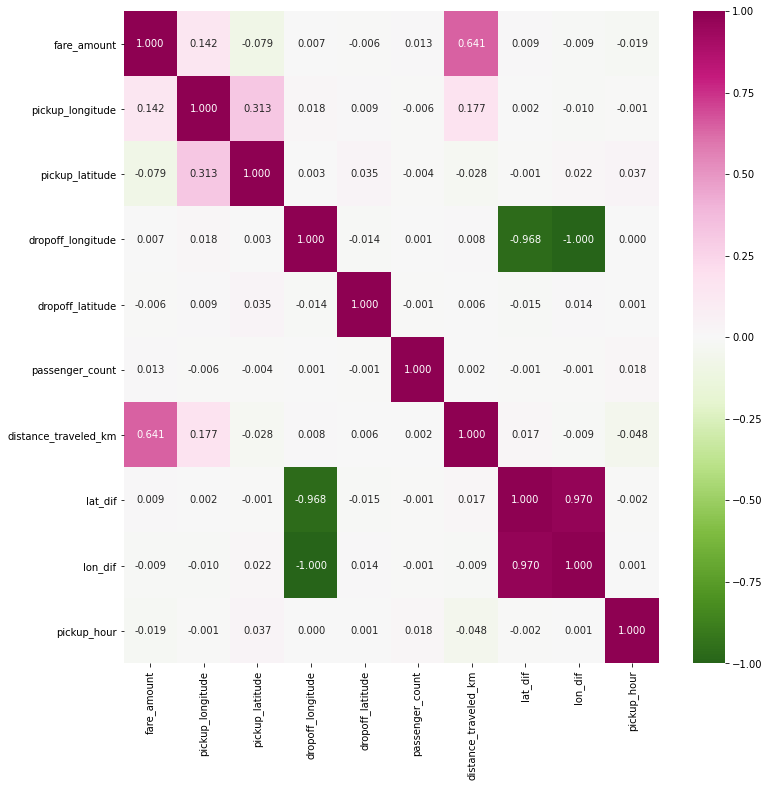

In [869]:
corrs = df.corr()

plt.figure(figsize = (12, 12))
sns.heatmap(corrs, annot = True, vmin = -1, vmax = 1, fmt = '.3f', cmap=plt.cm.PiYG_r);

In [870]:
fare_counts = df.groupby('fare_amount')['distance_traveled_km'].agg(['count', pd.Series.nunique]).sort_values('count', ascending = False)
fare_counts.head()

,count,nunique
fare_amount,,
6.5,46981,46981.0
4.5,39514,39514.0
8.5,36285,36285.0
5.3,28059,28059.0
5.7,27954,27954.0


Now prepare to train and test the model, create a train-test split.  I'll stratify the split using the previously created 'fare_bin' in order to avoid a lot of outliers.

Here, I'll use a linear regression to build the model.

In [871]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

lr = LinearRegression()

In [872]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_traveled_km,lat_dif,lon_dif,pickup_hour,fare_bin
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,17.231137,0.002701,114.562929,17,"(0.0, 5.0]"
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,246.295936,0.036780,114.690571,16,"(15.0, 20.0]"
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,55.251875,0.008504,114.752512,0,"(5.0, 10.0]"
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,38.152003,0.004437,114.724710,4,"(5.0, 10.0]"
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,74.122374,0.011440,114.724663,7,"(5.0, 10.0]"


create 4 groups: X_train (training group), X_test (test group), Y_train (target for training), Y_test (target for test)

In [873]:
RSEED = 100

X_train, X_valid, y_train, y_valid = train_test_split(df, np.array(df['fare_amount']), 
                                                      stratify = df['fare_bin'],
                                                      random_state = RSEED, test_size = 500_000)

Let's start by trying a model with a bunch of features, the initial features that may be relevant plus the features we added

In [874]:
lr.fit(X_train[['distance_traveled_km', 'lat_dif', 'lon_dif', 'pickup_hour', 'passenger_count']], y_train)

LinearRegression()

In [875]:
from sklearn.metrics import mean_squared_error

def metrics(train_pred, valid_pred, y_train, y_valid):
    """Root mean squared error and mean absolute percentage error"""
    
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    valid_rmse = np.sqrt(mean_squared_error(y_valid, valid_pred))
    
    train_ape = abs((y_train - train_pred) / y_train)
    valid_ape = abs((y_valid - valid_pred) / y_valid)
    
    train_mape = 100 * np.mean(train_ape)
    valid_mape = 100 * np.mean(valid_ape)
    
    return train_rmse, valid_rmse, train_mape, valid_mape

def evaluate(model, features, X_train, X_valid, y_train, y_valid):
    """Mean absolute percentage error"""
    
    train_pred = model.predict(X_train[features])
    valid_pred = model.predict(X_valid[features])
    
    train_rmse, valid_rmse, train_mape, valid_mape = metrics(train_pred, valid_pred,
                                                             y_train, y_valid)
    
    print(f'Training:   rmse = {round(train_rmse, 4)} \t mape = {round(train_mape, 4)}')
    print(f'Validation: rmse = {round(valid_rmse, 4)} \t mape = {round(valid_mape, 4)}')

evaluate(lr, ['distance_traveled_km', 'lat_dif', 'lon_dif', 'pickup_hour', 'passenger_count'], 
        X_train, X_valid, y_train, y_valid)

Training:   rmse = 4.5069 	 mape = 32.8932
Validation: rmse = 28.3964 	 mape = 33.6692


The rmse is way higher for training than for validation, so this looks like a case of overfitting. To fit this, I'll cut out features that are likely not explanatory

Now, I'll fit the linear regression to distance_traveled_km, passenger_count, and pickup_time

In [876]:
lr.fit(X_train[['distance_traveled_km', 'pickup_hour', 'passenger_count']], y_train)

LinearRegression()

In [877]:
from sklearn.metrics import mean_squared_error

def metrics(train_pred, valid_pred, y_train, y_valid):
    """Root mean squared error and mean absolute percentage error"""
    
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    valid_rmse = np.sqrt(mean_squared_error(y_valid, valid_pred))
    
    train_ape = abs((y_train - train_pred) / y_train)
    valid_ape = abs((y_valid - valid_pred) / y_valid)

    train_mape = 100 * np.mean(train_ape)
    valid_mape = 100 * np.mean(valid_ape)
    
    return train_rmse, valid_rmse, train_mape, valid_mape

def evaluate(model, features, X_train, X_valid, y_train, y_valid):
    """Mean absolute percentage error"""
    
    train_pred = model.predict(X_train[features])
    valid_pred = model.predict(X_valid[features])
    
    train_rmse, valid_rmse, train_mape, valid_mape = metrics(train_pred, valid_pred, y_train, y_valid)
    
    print(f'Training:   rmse = {round(train_rmse, 4)} \t mape = {round(train_mape, 4)}')
    print(f'Validation: rmse = {round(valid_rmse, 4)} \t mape = {round(valid_mape, 4)}')

evaluate(lr, ['distance_traveled_km', 'pickup_hour', 'passenger_count'], 
        X_train, X_valid, y_train, y_valid)

Training:   rmse = 4.5211 	 mape = 32.8314
Validation: rmse = 4.5186 	 mape = 32.7676


To determine the quality of this mode, I'll compare these metrics to a baseline of simply averaging the fare to get predictions

In [878]:
train_mean = y_train.mean()

# Create list of the same prediction for every observation
train_preds = [train_mean for _ in range(len(y_train))]
valid_preds = [train_mean for _ in range(len(y_valid))]

tr, vr, tm, vm = metrics(train_preds, valid_preds, y_train, y_valid)

print(f'Baseline Training:   rmse = {round(tr, 4)} \t mape = {round(tm, 4)}')
print(f'Baseline Validation: rmse = {round(vr, 4)} \t mape = {round(vm, 4)}')

Baseline Training:   rmse = 5.8894 	 mape = 50.6259
Baseline Validation: rmse = 5.8918 	 mape = 50.6201


By both metrics, the linear regression model does better

Now, to make a submission, I'll make predictions on the test data and save them to a csv

In [879]:
test = pd.read_csv('test.csv')

# add pickup_hour to test
def time_parse(time_str):
    time = time_str.split()[1]
    return int(time.split(":")[0])

test['pickup_hour'] = test.apply(lambda x: time_parse(x['pickup_datetime']), axis=1)

# add hav_distance to test
def hav_distance(lon1, lat1, lon2, lat2):
    # use sklearn's haversine function and multiply by Earth's radius to get distance in km
    return haversine_distances([[lon1, lat1], [lon2, lat2]])[0][1] * 6371000/1000

# create new feature using this function, distance in km
test['distance_traveled_km'] = test.apply(lambda x: hav_distance(x['pickup_longitude'], x['pickup_latitude'], 
                                                             x['dropoff_longitude'], x['dropoff_latitude']), axis=1)

In [882]:
preds = lr.predict(test[['distance_traveled_km', 'pickup_hour', 'passenger_count']])


sub = pd.DataFrame({'fare_amount': preds})
sub.to_csv('submission.csv', index = False)